In [39]:
import openslide 
import anndata
import scanpy as sc
import squidpy as sq
import os
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import csr_matrix
import pandas as pd

In [40]:
wsi_root = '/home/zhong/data/PGPD/WSI'
wsi_name = '40000.svs'

In [41]:
def get_wsi_image(wsi, level) -> np.array:
    level_count = wsi.level_count
    # assert level in level_count
    level_dimensions = wsi.level_dimensions[level]
    img = wsi.read_region((0, 0), level, level_dimensions) # 此处返回为PIL.Image格式，转化为np.array
    img = np.asarray(img, dtype=np.float32)[:, :, :3]/255
    return img

In [ ]:
# 读取WSI文件
wsi = openslide.OpenSlide(join(wsi_root, wsi_name))

# 获取WSI的信息
wsi_info = {
    'level_count': wsi.level_count,
    'level_dimensions': wsi.level_dimensions,
    'level_downsamples': wsi.level_downsamples,
    'properties': wsi.properties,
    'associated_images': wsi.associated_images
}
# thumbnail = wsi.get_thumbnail((1024, 1024))
# thumbnail = np.array(thumbnail)
# # 创建anndata对象
# 切割小块
# tiles = []
tile_size = 224.0

array_row, array_col, spatial = [], [], []
is_tissue = []
m = 0
for i in tqdm(range(0, wsi.dimensions[0], int(tile_size))):
    n=0
    for j in range(0, wsi.dimensions[1], int(tile_size)):
        tile = wsi.read_region((i, j), 0, (int(tile_size), int(tile_size)))
        tile = np.asarray(tile, dtype=np.float32)[:, :, :3]/255
        if i + int(tile_size) <= wsi.dimensions[0] and j + int(tile_size) <= wsi.dimensions[1]: 
            spatial.append([i+int(tile_size/2), j+int(tile_size/2)])
            is_tissue.append(0) if tile.mean() > 0.9 else is_tissue.append(1) 
            array_row.append(n)
            array_col.append(m)
        n+=1
    m+=1




In [52]:
spatial = np.array(spatial, dtype=int)
counts = csr_matrix(np.random.poisson(1, size=(spatial.shape[0], 5)), dtype=np.float32)
adata = anndata.AnnData(counts)
level = 2
tile_size = 224.0 # tile_size mod 2 == 0
# 添加WSI的信息
adata.uns['spatial'] = {}
adata.uns['spatial'][wsi_name] = {
    'images': {
        'hires': get_wsi_image(wsi, level=level)
    }, 
    'metadata': wsi_info, 
    'scalefactors': {
        'spot_diameter_fullres': tile_size-20,
        'tissue_hires_scalef': 1/wsi.level_downsamples[level],
        'fiducial_diameter_fullres': tile_size
    }
}

In [53]:
adata.obsm['spatial'] = spatial
adata.obs['array_row'] = array_row
adata.obs['array_col'] = array_col
adata.obs['is_tissue'] = is_tissue


In [54]:
adata.var_names = [f"dim_{i:d}" for i in range(adata.n_vars)]

In [8]:
# adata = adata[adata.obs['is_tissue'] == 1]
img = sq.im.ImageContainer(get_wsi_image(wsi, 0), layer="image")
# img

In [55]:
adata.uns['spatial'][wsi_name]['images']['hires'].shape

(1887, 1992, 3)

In [56]:
for scale in [1.0]:
    feature_name = f"features_summary_scale{scale}"
    data = sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        scale=scale
    )


# combine features in one dataframe



  0%|          | 0/19028 [00:00<?, ?/s]

In [57]:
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f],
    axis="columns",
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = anndata.utils.make_index_unique(
    adata.obsm["features"].columns
)

In [58]:
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata_ = anndata.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata_)
    # calculate leiden clustering
    sc.pp.pca(adata_, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata_)
    sc.tl.leiden(adata_, resolution=0.5)

    return adata_.obs["leiden"]

# adata.uns.pop('features_cluster_colors')
# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters


/home/zhong/miniconda3/envs/pathomics/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


In [61]:
wsi.close()

In [64]:
adata1 = adata[adata.obs['is_tissue']==1]
adata1

View of AnnData object with n_obs × n_vars = 11127 × 5
    obs: 'array_row', 'array_col', 'is_tissue', 'features_cluster'
    uns: 'spatial', 'features_cluster_colors'
    obsm: 'spatial', 'features_summary_scale1.0', 'features'

In [66]:
adata1.obsm['features']

,summary_ch-0_quantile-0.9,summary_ch-0_quantile-0.5,summary_ch-0_quantile-0.1,summary_ch-0_mean,summary_ch-0_std,summary_ch-1_quantile-0.9,summary_ch-1_quantile-0.5,summary_ch-1_quantile-0.1,summary_ch-1_mean,summary_ch-1_std,summary_ch-2_quantile-0.9,summary_ch-2_quantile-0.5,summary_ch-2_quantile-0.1,summary_ch-2_mean,summary_ch-2_std
542,0.909804,0.894118,0.878431,0.893611,0.015155,0.909804,0.894118,0.882353,0.894429,0.014480,0.909804,0.894118,0.882353,0.895041,0.013882
647,0.952941,0.929412,0.878431,0.912172,0.073962,0.945098,0.874510,0.792157,0.863196,0.091623,0.952941,0.917647,0.866667,0.905951,0.060054
648,0.949020,0.921569,0.870588,0.904903,0.069638,0.913725,0.854902,0.776471,0.841807,0.083523,0.937255,0.905882,0.858824,0.896424,0.055016
649,0.941176,0.901961,0.811765,0.880682,0.085657,0.890196,0.815686,0.690196,0.796811,0.099546,0.929412,0.890196,0.819608,0.875331,0.064414
650,0.937255,0.898039,0.776471,0.871826,0.091037,0.878431,0.807843,0.650980,0.780834,0.105752,0.925490,0.886275,0.792157,0.867175,0.067322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18718,0.956863,0.772549,0.584314,0.779609,0.138580,0.956863,0.772549,0.593726,0.781758,0.133699,0.956863,0.772549,0.611765,0.785821,0.126108
18848,0.964706,0.909804,0.780392,0.895528,0.066440,0.964706,0.909804,0.784314,0.896564,0.063758,0.964706,0.909804,0.796078,0.897954,0.059719
18849,0.964706,0.890196,0.772549,0.881730,0.078027,0.964706,0.890196,0.776471,0.882744,0.076206,0.964706,0.890196,0.784314,0.884312,0.073887
18981,0.956863,0.858824,0.792157,0.866523,0.056605,0.956863,0.858824,0.796078,0.866789,0.053712,0.949020,0.862745,0.803922,0.868091,0.049206


/home/zhong/miniconda3/envs/pathomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
Exception ignored in: <function _OpenSlide.__del__ at 0x7fecd0082200>
Traceback (most recent call last):
  File "/home/zhong/miniconda3/envs/pathomics/lib/python3.10/site-packages/openslide/lowlevel.py", line 139, in __del__
AttributeError: '_OpenSlide' object has no attribute '_valid'


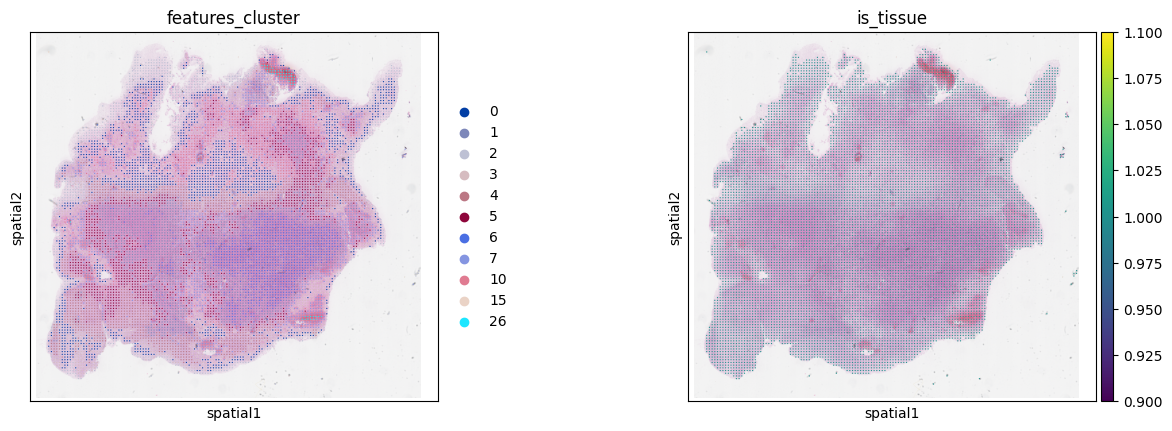

In [65]:
sc.pl.spatial(adata1, color=["features_cluster", "is_tissue"],size=0.5)

Exception ignored in: <function _OpenSlide.__del__ at 0x7fbc4ea26200>
Traceback (most recent call last):
  File "/home/zhong/miniconda3/envs/pathomics/lib/python3.10/site-packages/openslide/lowlevel.py", line 139, in __del__
    if self._valid:
AttributeError: '_OpenSlide' object has no attribute '_valid'
Exception ignored in: <function _OpenSlide.__del__ at 0x7fbc4ea26200>
Traceback (most recent call last):
  File "/home/zhong/miniconda3/envs/pathomics/lib/python3.10/site-packages/openslide/lowlevel.py", line 139, in __del__
    if self._valid:
AttributeError: '_OpenSlide' object has no attribute '_valid'
Exception ignored in: <function _OpenSlide.__del__ at 0x7fbc4ea26200>
Traceback (most recent call last):
  File "/home/zhong/miniconda3/envs/pathomics/lib/python3.10/site-packages/openslide/lowlevel.py", line 139, in __del__
    if self._valid:
AttributeError: '_OpenSlide' object has no attribute '_valid'


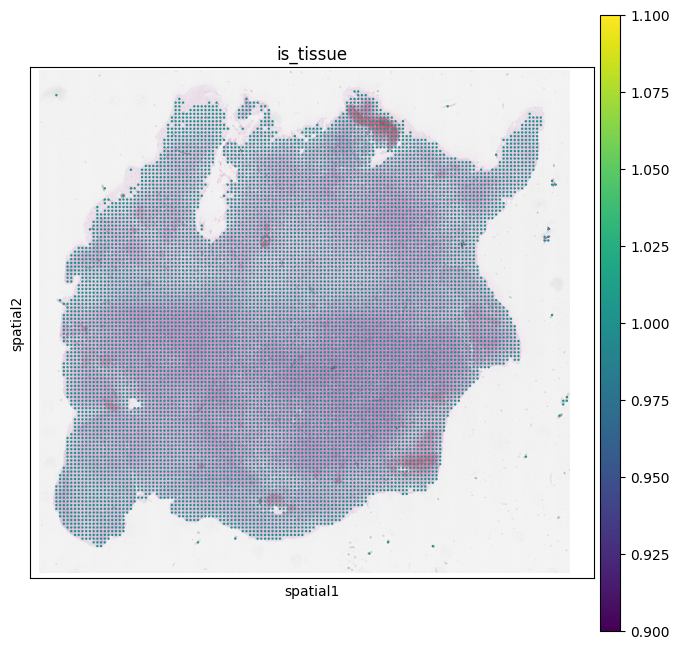

In [22]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, color=['is_tissue'], size=0.7)

In [70]:
adata.uns['spatial'][wsi_name].pop('metadata')
adata.write(f'{wsi_name}.h5ad', compression="gzip")